In [1]:
import pandas as pd
import nltk
import pickle
from statistics import mode
import numpy as np
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Error loading wordnet: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>


In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
text = pd.read_csv("E:\7th sem\Minor Project\code\Datasets\dataset.csv")

In [ ]:
input_data = text['abstract']
target_data = text['title']

In [ ]:
def clean_data(text,src):
  stemm=LancasterStemmer() 
  stop_words = stopwords.words('english')
  text =text.replace(r'[^\w\s]+', '')  
  text= text.replace(r'[@_!#$%^&*()<>?/\|}{~:]', '') 
  text= text.replace(r"<(\"[^\"]*\"|'[^']*'|[^'\">])*>", '')   
  words=word_tokenize(text.lower())  
  if src == "inputs":
   words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [ ]:
input_texts = []
target_texts = []
input_words = []
target_words = []
for in_text,tr_text in zip(input_data,target_data):
    in_words = clean_data(in_text,"inputs")
    input_texts += [" ".join(in_words)]
    input_words += in_words
    tr_words = clean_data("sos "+tr_text+" eos","targets")
    target_texts += [" ".join(tr_words)]
    target_words += tr_words

    
    

In [ ]:
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_len = len(input_words)
num_tr_len = len(target_words)

max_input_len = mode([len(i) for i in input_texts])
max_target_len = mode([len(i) for i in target_texts])

print(num_in_len,num_tr_len,max_input_len, max_target_len)

69844 24247 456 68


In [ ]:
def get_sequence_of_token(input_data,max_length):
  tokenizer = Tokenizer()  
  tokenizer.fit_on_texts(input_data)  
  input_data = tokenizer.texts_to_sequences(input_data) 
  padded_data = pad_sequences(input_data,  maxlen=max_length, padding = 'post') 
  return padded_data

In [ ]:
K.clear_session()
latent_dim = 256

en_input = Input(shape = (max_input_len))
en_embedding  = Embedding(num_in_len+1, latent_dim)(en_input)


In [ ]:
#encoder
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_output1, state_h1, state_c1 = en_lstm1(en_embedding)

en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_output2, state_h2, state_c2= en_lstm2(en_output1) 

en_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True)
en_output3 , state_h3 , state_c3= en_lstm3(en_output2)



en_states= [state_h3, state_c3]

In [ ]:
#decoder
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_len+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs)

dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states)

In [ ]:
#attention
attention =Attention()
attn_out = attention([dec_outputs,en_output3]) 

merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [ ]:
dec_dense = Dense(num_tr_len+1, activation='softmax') 
dec_outputs = dec_dense(merge)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 456, 256)     17880320    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 456, 256),   525312      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

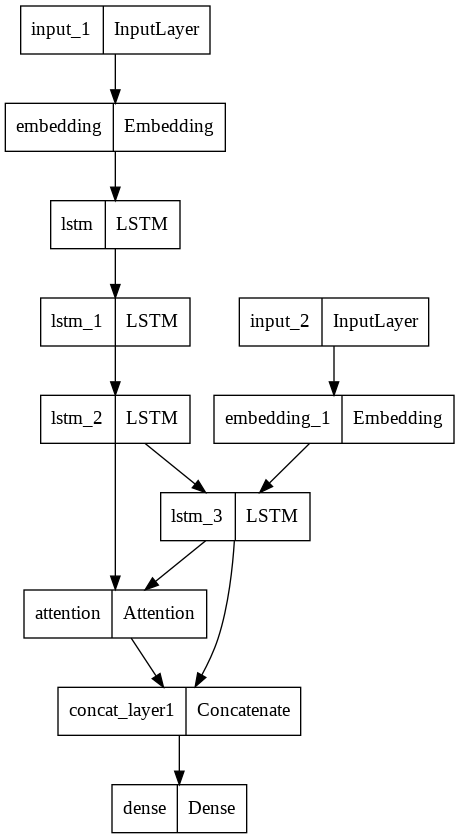

In [ ]:
model = Model([en_input, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png')

In [ ]:
model.compile(optimizer = "rmsprop",loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kfold.split(input_data):
  x_train, x_test, y_train, y_test = input_data[train_index], input_data[test_index],target_data[train_index],target_data[test_index]
  en_input_data = get_sequence_of_token(x_train,max_input_len)
  dec_data = get_sequence_of_token(y_train,max_target_len)
  x_test_data = get_sequence_of_token(x_test,max_input_len)
  y_test_data = get_sequence_of_token(y_test,max_target_len)
  dec_input_data = dec_data[:,:-1]
  dec_target_data = dec_data.reshape(len(dec_data),max_target_len,1)[:,1:]
  y_test_input = y_test_data[:,:-1]
  y_test_target= y_test_data.reshape(len(y_test_data),max_target_len,1)[:,1:]
  model.fit([en_input_data, dec_input_data], dec_target_data,batch_size=128,validation_data=([x_test_data,y_test_input],y_test_target))
model.save('/content/drive/MyDrive/Colab Notebooks/models/Title_Generation13.tf')

In [ ]:
from matplotlib import pyplot
pyplot.plot(loss, label='train loss')
pyplot.plot(val_loss, label='test loss')
pyplot.legend()
pyplot.show()

In [ ]:
pyplot.plot(accuracy, label='train acc')
pyplot.plot(val_accuracy, label='test acc')
pyplot.legend()
pyplot.show()

In [ ]:
model = models.load_model("/content/drive/MyDrive/Colab Notebooks/models/Title_Generation13.tf")

In [ ]:

en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]

en_model = Model(model.input[0],[en_outputs]+en_states)

In [ ]:
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_input_len,latent_dim))
 
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
in_tokenizer = Tokenizer()
tr_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(input_data)
tr_tokenizer.fit_on_texts(target_data)
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

In [ ]:
def decode_sequence(input_seq):
    en_out, en_h, en_c = en_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
    stop_condition = True
    decoded_sentence = ""
    while stop_condition:
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])
        word_index = np.argmax(output_words[0,-1:])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word + " "       
        if text_word == "eos" or len(decoded_sentence.split()) >= max_target_len:
            stop_condition = False       
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c   
    return decoded_sentence

In [ ]:
inp_abstract = input("Enter : ")
print("Abstract :",inp_abstract)
inp_abstract = clean_data(inp_abstract,"inputs")
inp_abstract = ' '.join(inp_abstract)
inp_x= in_tokenizer.texts_to_sequences([inp_abstract]) 
inp_x= pad_sequences(inp_x,  maxlen=max_input_len, padding='post') 
title=decode_sequence(inp_x.reshape(1,max_input_len))
if 'eos' in title :
  title=title.replace('eos','')
print("\nPredicted Title:",title);print("\n")